# Generate figures

This notebook aims to generate figures to serve as resources for creating diagrams in the report.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
import gc

np.random.seed(1000)

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()

In [2]:
# Read pre-processed data
save_file = "data/gse176269_raw_covid_normalized_preprocessed.h5ad"
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 28337 × 2500
    obs: 'sampID', 'plateID', 'status', 'donorID', 'cDate', 'age', 'sex', 'tSNE1', 'tSNE2', 'group', 'cellType', 'SARS.CoV.2', 'fluA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'sampleID'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'plateID_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
# Delete 'X_umap' for this experiment.
#del adata.obsm['X_umap']
del adata.uns['neighbors']
del adata.uns['pca']
del adata.obsm['X_pca']
#del adata.uns['umap']
#del adata.varm['PCs']
del adata.obsp
gc.collect()

0

In [4]:
del adata.obsm['X_umap']

In [10]:
# Select random samples from the list of samples. 
# The number of samples is 10.
# Make a new column that has the combined information of the sampleID and CoVID-19 severity.
adata.obs['sampleID'] = adata.obs['sampleID'].astype('str')

list_samples = list(adata.obs["sampleID"].unique())
control_samples = []
covid_samples  = []
for l in list_samples:
    if 'HC' in l or 'f'in l:
        control_samples.append(l)
    else:
        covid_samples.append(l)
        
num_samples = 5
covid_random_samples = np.random.choice(covid_samples, num_samples, replace=False)
control_random_samples = np.random.choice(control_samples, num_samples, replace=False)
print("Randomly selected covid samples: ", covid_random_samples)
print("Randomly selected control samples: ", control_random_samples)

# Concatenate covid anmd control random selected samples.
random_samples = np.concatenate((covid_random_samples, control_random_samples))


Randomly selected covid samples:  ['Cov0502' 'Cov1204' 'Cov0402' 'Cov16N03' 'Cov0403']
Randomly selected control samples:  ['f8202' 'HC1704' 'f7803' 'f83a02' 'HC3302']


In [11]:
# Then filter the adata object based on the selected samples.
adata = adata[adata.obs["sampleID"].isin(random_samples), :]

Split the dataset into Train: 80% and Test: 20%

In [20]:
from sklearn.model_selection import train_test_split

list_samples = list(adata.obs["sampleID"].unique())
y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=11100)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)  # 4 samples
print("Samples for testing:", y_test)  # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['Cov1204', 'f7803', 'Cov0403', 'Cov0402', 'f83a02', 'f8202', 'Cov16N03', 'HC1704']
Samples for testing: ['Cov0502', 'HC3302']


Make a copied adata. Then get the cell bercode corresponding to the samples of the train data.

In [21]:
### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs["contain_y_train"] = adata.obs["sampleID"].isin(y_train)

# Copy adata
adata_train = adata.copy()
# Remove cells that don't belong to y_train
adata_train = adata_train[adata_train.obs["contain_y_train"] == True, :]


### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs["contain_y_test"] = adata.obs["sampleID"].isin(y_test)

# Copy adata
adata_test = adata.copy()
# Remove cells that don't belong to y_train
adata_test = adata_test[adata_test.obs["contain_y_test"] == True, :]

del adata
gc.collect()

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_54828/426524661.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["contain_y_train"] = adata.obs["sampleID"].isin(y_train)


1302

In [22]:
# Get unique sample names
def get_unique_sample_names(adata):
    list_samples = list(adata.obs["sampleID"].unique())
    return list_samples

print("Sample names for training:", get_unique_sample_names(adata_train))
print("sample names for testing:", get_unique_sample_names(adata_test))

Sample names for training: ['Cov0402', 'Cov0403', 'Cov1204', 'Cov16N03', 'HC1704', 'f7803', 'f8202', 'f83a02']
sample names for testing: ['Cov0502', 'HC3302']


Apply UMAP to the train adata.

Make sure both adata (train/refrence and test) have the same genes.

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


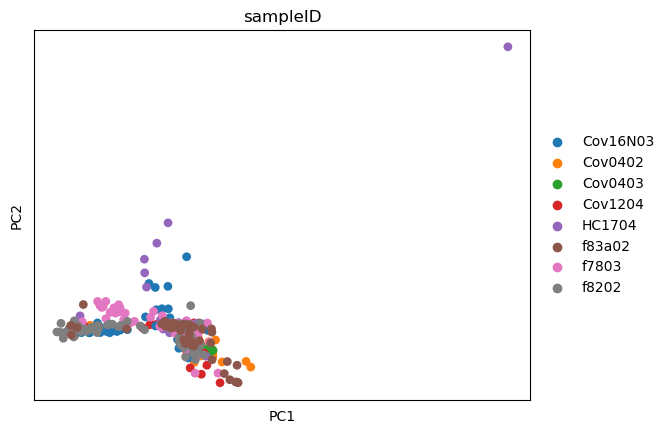

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


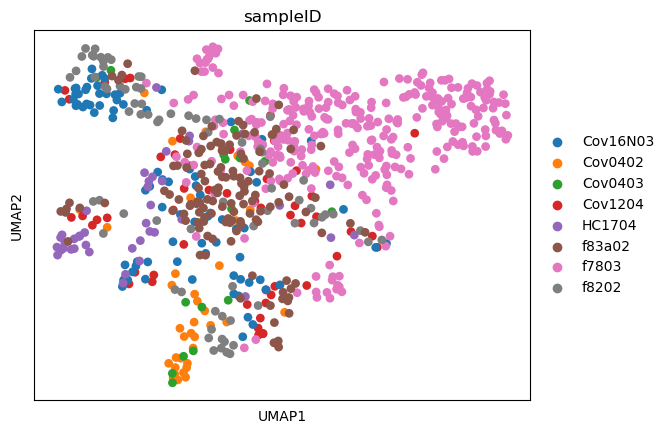

In [23]:
sc.pp.neighbors(adata_train, n_pcs=30, n_neighbors=20)
sc.tl.pca(adata_train)
sc.pl.pca(adata_train, color="sampleID")
sc.tl.umap(adata_train)
sc.pl.umap(adata_train, color="sampleID")

In [24]:
# Make covid_non_covid column
list_covid_non_covid = []
for index, row in adata_train.obs.iterrows():
    if "Cov" in row['sampleID']:
        list_covid_non_covid.append('covid')
    else:
        list_covid_non_covid.append('non_covid')

adata_train.obs['covid_non_covid'] = list_covid_non_covid

list_covid_non_covid = []
for index, row in adata_test.obs.iterrows():
    if "Cov" in row['sampleID']:
        list_covid_non_covid.append('covid')
    else:
        list_covid_non_covid.append('non_covid')

adata_test.obs['covid_non_covid'] = list_covid_non_covid

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_54828/3337970774.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['covid_non_covid'] = list_covid_non_covid


/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


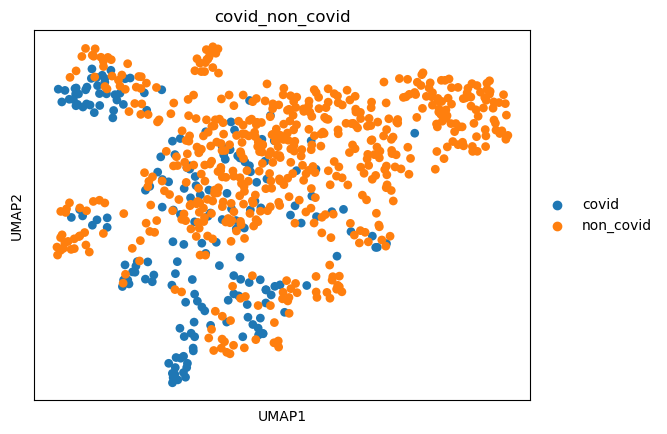

In [25]:
sc.pl.umap(adata_train, color="covid_non_covid")

Ingest the `adata_test`: new samples based on the `adata_train`: existing samples used as reference data to fit the UMAP reducer.

In [12]:
# sc.pp.neighbors(adata_test, n_pcs = 30, n_neighbors = 20)
# sc.tl.umap(adata_test)

In [13]:
# add a new metadata field to adata_test with the original sample labels
# adata_test.obs['original_sample_labels'] = adata_test.obs['sample']

In [26]:
# sc.tl.ingest(adata_test, adata_train, obs='sample', embedding_method='umap')
sc.tl.ingest(adata_test, adata_train, embedding_method="umap")

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


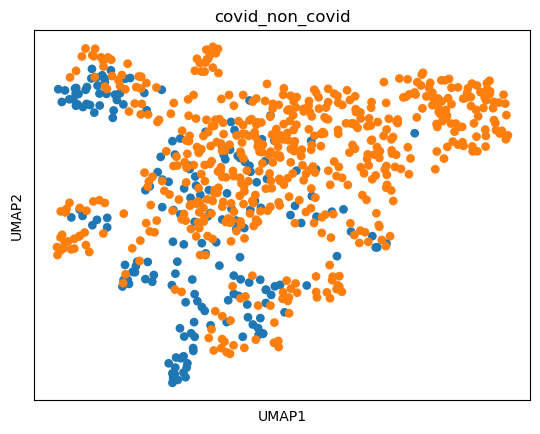

In [27]:
sc.pl.umap(adata_train, color="covid_non_covid", save="_adata_train_small.png", legend_loc='lower right')

In [28]:
adata_test.obs["sampleID"].unique()

array(['Cov0502', 'HC3302'], dtype=object)

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


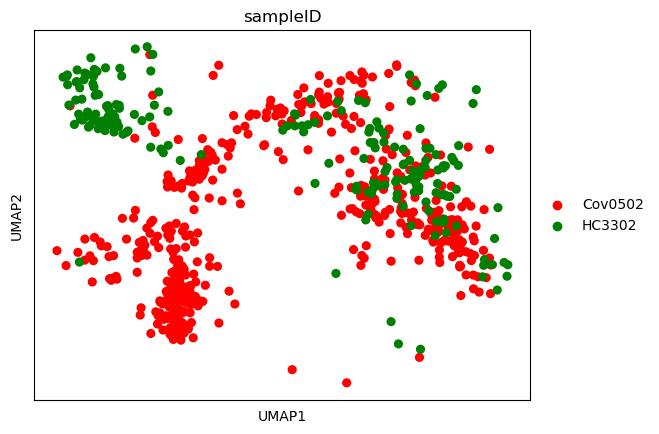

In [29]:
sc.pl.umap(adata_test, color="sampleID", 
           palette={"Cov0502": "red",
                    "HC3302": "green"}, save="_adata_test_small_ingest.png")

In [30]:
adata = adata_train.concatenate(adata_test, batch_categories=["ref", "new"])

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [19]:
basis_values = adata.obsm['X_umap']

sample_vector = adata.obs['sampleID_label'].values
covid_non_covid_vector = adata.obs['covid_non_covid'].values
batch_vector = adata.obs['batch'].values


df_pds = pd.DataFrame(list(zip(basis_values, sample_vector, batch_vector, covid_non_covid_vector)),
               columns =['basis_value', 'sample', 'batch', 'covid_non_covid'])

del basis_values
del sample_vector
del covid_non_covid_vector
del batch_vector

In [20]:
ext_covid_vector = df_pds.query("batch == 'ref' and not sample.str.contains('control')")['basis_value'].values
ext_non_covid_vector = df_pds.query("batch == 'ref' and sample.str.contains('control')")['basis_value'].values

new_covid_vector = []

for v in ext_covid_vector:
    new_covid_vector.append(list(v))

new_non_covid_vector = []

for v in ext_non_covid_vector:
    new_non_covid_vector.append(list(v))

ext_covid_vector = np.array(new_covid_vector)
ext_non_covid_vector = np.array(new_non_covid_vector)

print(f"Number of cells from selected covid samples: {len(ext_covid_vector)}")
print(f"Number of cells from selected non-covid samples: {len(ext_non_covid_vector)}")

Number of cells from selected covid samples: 17621
Number of cells from selected non-covid samples: 25097


In [21]:
x_covid = ext_covid_vector[:, 0]
y_covid = ext_covid_vector[:, 1]
x_n_covid = ext_non_covid_vector[:, 0]
y_n_covid = ext_non_covid_vector[:, 1]

# now determine nice limits by hand:
#binwidth = 0.25
binwidth = 1
xymax = np.max([np.max(np.fabs(x_covid)), np.max(np.fabs(y_covid))])
lim = (int(xymax/binwidth) + 1) * binwidth
n_sample_covid = np.linspace(-lim+5, lim+5, len(ext_covid_vector))

del ext_covid_vector
del ext_non_covid_vector

kernel_x_covid = stats.gaussian_kde(x_covid)
kernel_y_covid = stats.gaussian_kde(y_covid)
kernel_x_n_covid = stats.gaussian_kde(x_n_covid)
kernel_y_n_covid = stats.gaussian_kde(y_n_covid)
 #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)
#n_sample_non_covid = np.linspace(-lim+5, lim+5, len(ext_covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)

# KDE for UMAP1 (x-axis)
kde_x_covid = kernel_x_covid(n_sample_covid)
kde_x_n_covid = kernel_x_n_covid(n_sample_covid)

# KDE for UMAP2 (y-axis)
kde_y_covid = kernel_y_covid(n_sample_covid)
kde_y_n_covid = kernel_y_n_covid(n_sample_covid)

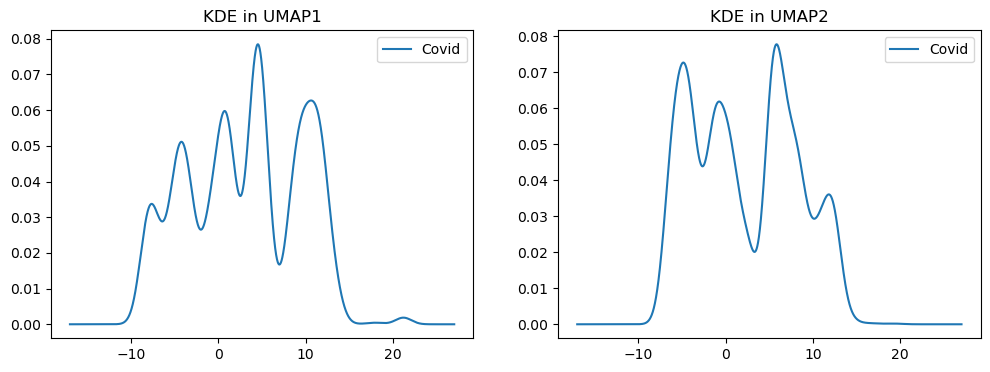

In [22]:
# Initialise the subplot function using number of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# For Covid KDE
ax1.plot(n_sample_covid, kde_x_covid, label='Covid')
#ax1.plot(n_sample_covid, kde_x_n_covid, label='Non Covid')
ax1.legend()
ax1.set_title("KDE in UMAP1")

ax2.plot(n_sample_covid, kde_y_covid, label='Covid')
#ax2.plot(n_sample_covid, kde_y_n_covid, label='Non Covid')
ax2.legend()
ax2.set_title("KDE in UMAP2")

# Save the figure
plt.savefig("./figures/kde_exist_covid.png", dpi=300, bbox_inches='tight')

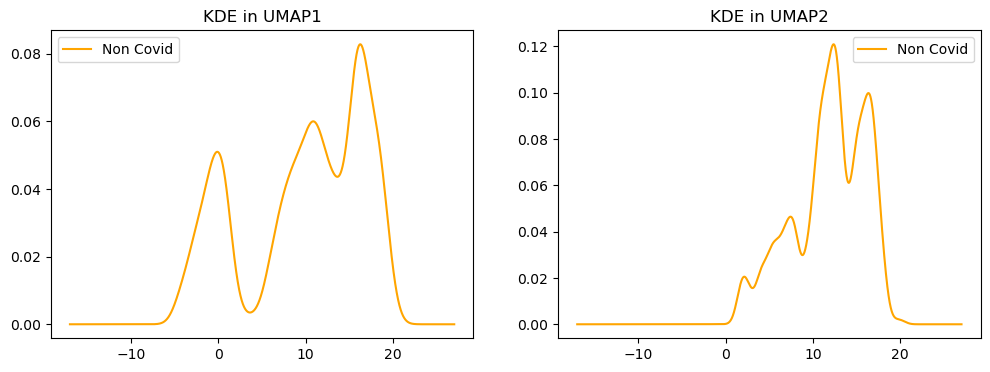

In [23]:
# Initialise the subplot function using number of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# For Covid KDE
#ax1.plot(n_sample_covid, kde_x_covid, label='Covid')
ax1.plot(n_sample_covid, kde_x_n_covid, label='Non Covid', color='orange')
ax1.legend()
ax1.set_title("KDE in UMAP1")

#ax2.plot(n_sample_covid, kde_y_covid, label='Covid')
ax2.plot(n_sample_covid, kde_y_n_covid, label='Non Covid', color='orange')
ax2.legend()
ax2.set_title("KDE in UMAP2")

plt.savefig("./figures/kde_exist_non_covid.png", dpi=300, bbox_inches='tight')

In [24]:
y_test = df_pds.query("batch == 'new'")['sample'].unique()

dict_sample_vec = {} #Key: sample_name, value: basis value as [UMAP1, UMAP2]

for s in y_test:
    dict_sample_vec[s] = np.stack(list(df_pds.query(f"sample == '{s}'")['basis_value'].values[:]))
    print(f"Sample: {s}, size of vecor {len(dict_sample_vec[s])}")

Sample: S-S017_severe/critical, size of vecor 5221
Sample: S-HC007_control, size of vecor 7074


In [25]:
import numpy as np  
from scipy.stats import norm  
from matplotlib import pyplot as plt

#compute KL Divergence
"""KL Divergence(P|Q)"""
def KL_div(p_probs, q_probs):    
    KL_div = p_probs * np.log(p_probs / q_probs)
    return np.sum(KL_div)

result_UMAP1_pred = dict() # Key: sample_name, value: #[Comparison with the exsiting covid sample, Comarison with existing non-covid sample]
result_pred = dict() # Key: sample_name, value: #[Avg of the exsiting covid sample's KL-divergence score between UMAP1 and UMAP2, Avg of the exsiting non-covid sample's KL-divergence score between UMAP1 and UMAP2]

--------Done computing KL-divergence with new samples--------
result_pred: {}


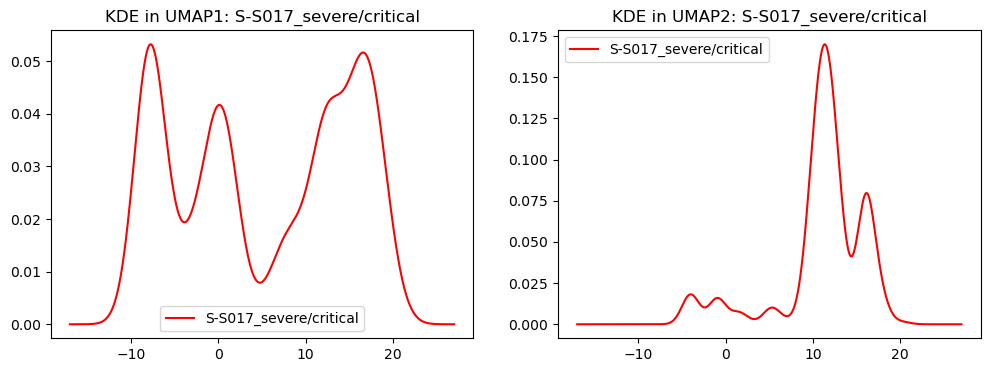

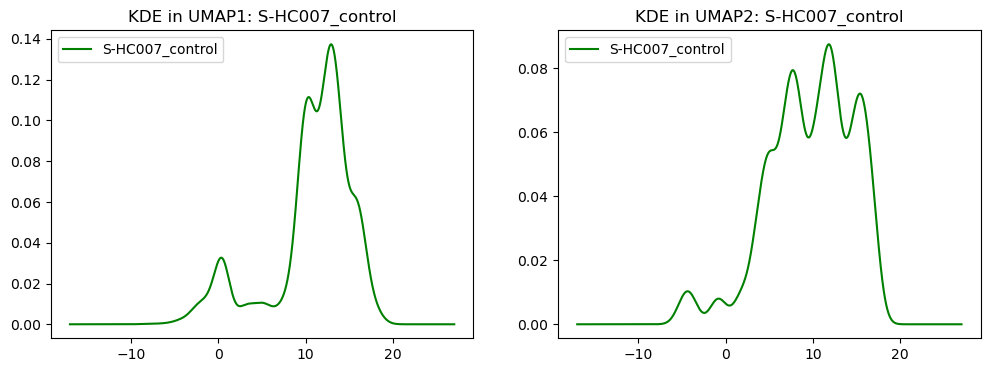

: 

In [29]:
for s, vec in dict_sample_vec.items():
    x_vec = vec[:, 0]
    y_vec = vec[:, 1]

    #Compute kernels of KDE for UMAP1: x-axis and UMAP2: y-axis
    kernel_x = stats.gaussian_kde(x_vec)
    kernel_y = stats.gaussian_kde(y_vec)

    # KDE for UMAP1 (x-axis)
    kde_x_test = kernel_x(n_sample_covid)

    # KDE for UMAP2 (y-axis)
    kde_y_test = kernel_y(n_sample_covid)

    # Get KL-divergence in UMAP 1: x-axis between the existing samples and test sample
    x_KL_d_exis_covid = KL_div(kde_x_covid, kde_x_test)
    x_KL_d_exis_non_covid = KL_div(kde_x_n_covid, kde_x_test)
    # Get KL-divergence in UMAP 2: y-axis between the existing samples and test sample
    y_KL_d_exis_covid = KL_div(kde_y_covid, kde_y_test)
    y_KL_d_exis_non_covid = KL_div(kde_y_n_covid, kde_y_test)

    
    # Initialise the subplot function using number of rows and columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if 'control' in s:
        ax1.plot(n_sample_covid, kde_x_test, label=s, color='green')
        ax1.legend()
        ax1.set_title(f"KDE in UMAP1: {s}")

        #ax2.plot(n_sample_covid, kde_y_covid, label='Covid')
        ax2.plot(n_sample_covid, kde_y_test, label=s, color='green')
        ax2.legend()
        ax2.set_title(f"KDE in UMAP2: {s}")
    else:
        ax1.plot(n_sample_covid, kde_x_test, label=s, color='red')
        ax1.legend()
        ax1.set_title(f"KDE in UMAP1: {s}")

        #ax2.plot(n_sample_covid, kde_y_covid, label='Covid')
        ax2.plot(n_sample_covid, kde_y_test, label=s, color='red')
        ax2.legend()
        ax2.set_title(f"KDE in UMAP2: {s}")
        
    # if s has a /, replace it with _
    s = s.replace('/', '_')
    # Save the figure
    plt.savefig(f"./figures/{s}.png", dpi=300, bbox_inches='tight')

print("--------Done computing KL-divergence with new samples--------")
print("result_pred:", result_pred)